In [20]:
import torch
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import random
from transformers import PreTrainedModel, AutoModelForSeq2SeqLM, AutoTokenizer
# from model.ours.nlq_head import NLQHead
import torch.nn as nn
import os

# model_path = '/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/outputs/batch/2024-06-07/17-03-43/lit/103204/checkpoints/step=3834-nlq_R5@0.3=0.0000.ckpt'
# model_path = '/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/outputs/batch/2024-06-08/18-40-03/lit/103410/checkpoints/step=4752-nlq_R5@0.3=0.0000.ckpt'
model = SentenceTransformer('all-mpnet-base-v2').cuda().eval()
# model.load_state_dict(
#     {k.replace('model.model.', '0.auto_model.'): v for k, v in torch.load(model_path)['state_dict'].items()},
#     strict=False
# )

In [33]:
annotations = json.loads(Path(os.path.join('/data/soyeonhong/GroundVQA/data/unified/annotations.NLQ_train.json')).read_text())
valid_video_id = [annotation['video_id'] for annotation in annotations]

p_caps_dir = Path('/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/data/captions/llava-v1.6-34b/global')
# p_caps_dir = Path('/data/gunsbrother/prjs/ltvu/llms/LLaVA-NeXT/work_dirs/LLaVA-NeXT-Video-7B-DPO/global')
p_caps = list(p_caps_dir.glob('*.json'))

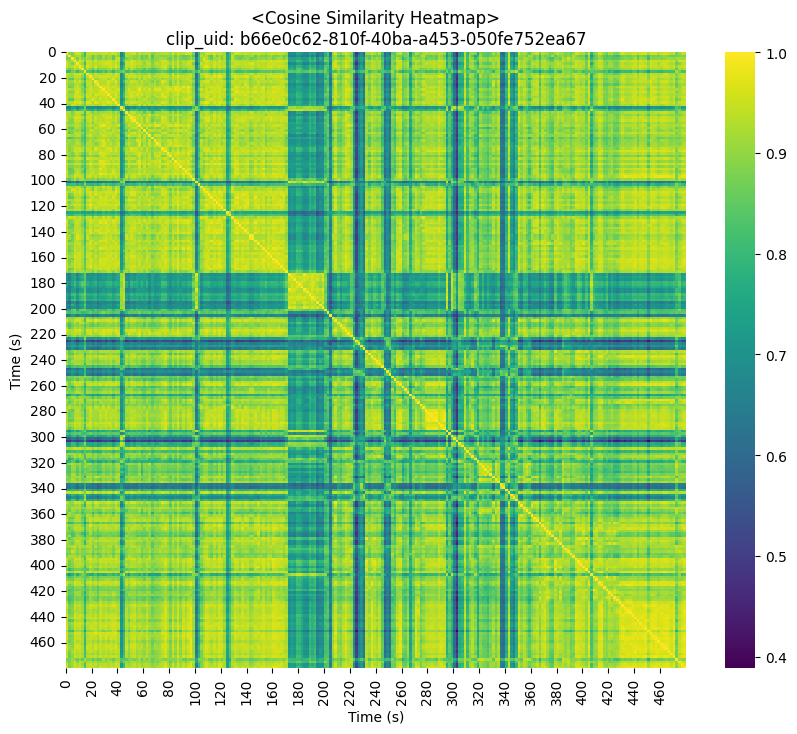

b66e0c62-810f-40ba-a453-050fe752ea67


In [26]:
idx = random.randint(0, len(valid_video_id) - 1)


for p_cap in p_caps:
    if valid_video_id[idx] in p_cap.stem:
        break
# p_cap = p_caps[idx]

cap_data = json.load(p_cap.open())['answers']
# time = [int(entry[0] / 30) for entry in cap_data]
time = [int(entry[0][0] / 30) for entry in cap_data]

# caps = []
# for entry in cap_data:
#     sentences = entry[2].split('. ')
#     entry_idx = random.randint(0, len(sentences) - 1)
#     caps.append(sentences[entry_idx])
caps = [entry[2] for entry in cap_data]

embeddings = model.encode(caps)

cos_sim = embeddings @ embeddings.T


plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, cmap='viridis')
plt.xticks(range(0, len(time), 10), [time[i] for i in range(0, len(time), 10)], rotation=90)
plt.yticks(range(0, len(time), 10), [time[i] for i in range(0, len(time), 10)], rotation=0)
# plt.gca().axes.xaxis.set_visible(False)
# plt.gca().axes.yaxis.set_visible(False)

plt.xlabel('Time (s)')
plt.ylabel('Time (s)')

plt.title(f'<Cosine Similarity Heatmap>\nclip_uid: {p_cap.stem}')
plt.show()

print(p_cap.stem)

In [17]:
class GroundVQA(nn.Module):
    def __init__(self, lm_path='google/flan-t5-base', input_dim=2304, freeze_word=False, max_v_len=256):
        super().__init__()

        if not isinstance(input_dim, int):
            input_dim = input_dim.v_dim

        self.lm: PreTrainedModel = AutoModelForSeq2SeqLM.from_pretrained(lm_path, local_files_only=True)

        lm_dim = self.lm.get_input_embeddings().embedding_dim
        self.lm_proj = nn.Linear(input_dim, lm_dim)
        self.v_emb = nn.Parameter(torch.randn((1, 1, lm_dim)))
        if freeze_word:
            for name, param in self.lm.named_parameters():
                if 'shared' in name:
                    param.requires_grad = False

        self.nlq_head = NLQHead(in_dim=lm_dim, max_v_len=max_v_len)

In [4]:
model = GroundVQA().cuda().eval()
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')
lm = model.lm

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


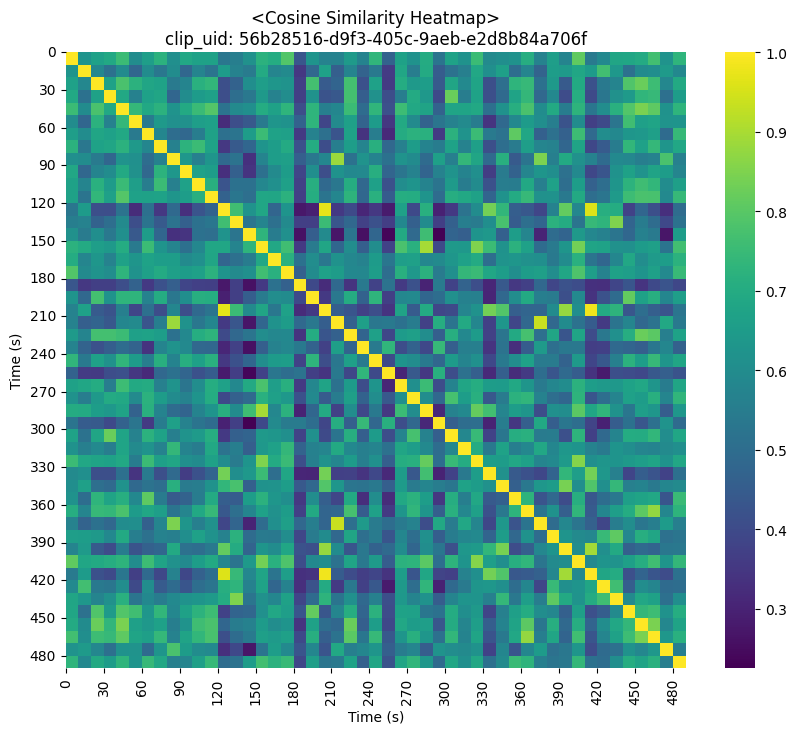

tensor([[-0.0351,  0.0906, -0.0192,  ...,  0.0185,  0.0016,  0.0213],
        [-0.0235,  0.0461, -0.0728,  ...,  0.0178,  0.0163,  0.0045],
        [-0.0406,  0.0942, -0.0102,  ...,  0.0483, -0.0037,  0.0115],
        ...,
        [-0.0288,  0.0729, -0.0122,  ...,  0.0264,  0.0202,  0.0100],
        [-0.0616,  0.0794, -0.0467,  ...,  0.0489,  0.0220, -0.0023],
        [-0.0600,  0.0795, -0.0208,  ...,  0.0287,  0.0020,  0.0219]],
       device='cuda:0')

In [40]:
tokens = tokenizer(caps, return_tensors='pt', padding=True, truncation=False)
tokens = tokens.to('cuda')

with torch.no_grad():
    cap_feat = lm.encoder.embed_tokens(tokens['input_ids'])
                    
    out = lm.encoder(
        inputs_embeds=cap_feat,
        attention_mask=tokens['attention_mask'],
    ).last_hidden_state

    out = out.mean(dim=1)
    
# normalize and calculate cos sim
out = out / out.norm(dim=1, keepdim=True)
cos_sim = out @ out.T

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim.cpu(), cmap='viridis')
plt.xticks(range(0, len(time), 3), [time[i] for i in range(0, len(time), 3)], rotation=90)
plt.yticks(range(0, len(time), 3), [time[i] for i in range(0, len(time), 3)], rotation=0)

plt.xlabel('Time (s)')
plt.ylabel('Time (s)')

plt.title(f'<Cosine Similarity Heatmap>\nclip_uid: {p_cap.stem}')
plt.show()

out

In [36]:
from transformers import AutoModel, AutoTokenizer

state_dict = torch.load('/data/gunsbrother/prjs/ltvu/everything/sbert_finetune/data/checkpoints/egovlp-config-removed.pth', map_location='cpu')
new_state = {}
for k, v in state_dict['state_dict'].items():
    if k.startswith('module.text_model.'):
        new_state[k.replace('module.text_model.', '')] = v
model = AutoModel.from_pretrained('distilbert-base-uncased', local_files_only=False, state_dict=new_state).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/data/soyeonhong/anaconda3/envs/groundvqa/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


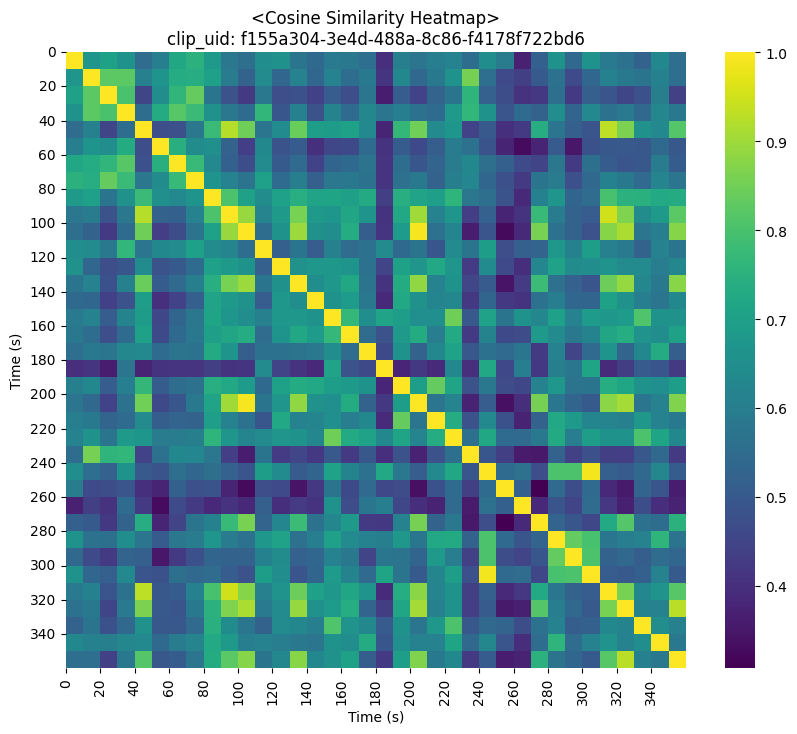

f155a304-3e4d-488a-8c86-f4178f722bd6


In [80]:
idx = random.randint(0, len(valid_video_id) - 1)


for p_cap in p_caps:
    if valid_video_id[idx] in p_cap.stem:
        break
# p_cap = p_caps[idx]

cap_data = json.load(p_cap.open())['answers']
time = [int(entry[0] / 30) for entry in cap_data]

caps = []
for entry in cap_data:
    sentences = entry[2].split('. ')
    # entry_idx = random.randint(0, len(sentences) - 1)
    caps.append(sentences[0])
# caps = [entry[2] for entry in cap_data]

tokens = tokenizer(caps, return_tensors='pt', padding=True, truncation=False)

with torch.no_grad():
    tokens = {k: v.cuda() for k, v in tokens.items()}
    embeddings = model(**tokens).last_hidden_state[:, 0]
    
embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
cos_sim = embeddings @ embeddings.T


plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim.cpu(), cmap='viridis')
plt.xticks(range(0, len(time), 2), [time[i] for i in range(0, len(time), 2)], rotation=90)
plt.yticks(range(0, len(time), 2), [time[i] for i in range(0, len(time), 2)], rotation=0)
# plt.gca().axes.xaxis.set_visible(False)
# plt.gca().axes.yaxis.set_visible(False)

plt.xlabel('Time (s)')
plt.ylabel('Time (s)')

plt.title(f'<Cosine Similarity Heatmap>\nclip_uid: {p_cap.stem}')
plt.show()

print(p_cap.stem)